# Lecture 11 In-Class Activity: DTW & k-NN

**Goal (30 min):**
1. Implement DTW distance algorithm
2. Use DTW for machine learning (k-NN classifier)

---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## Part 1: Load Two Different Gestures

Let's compare two different gestures

Gesture 1 (Tennis):  140 samples
Gesture 2 (Bowling): 116 samples
Different lengths: True


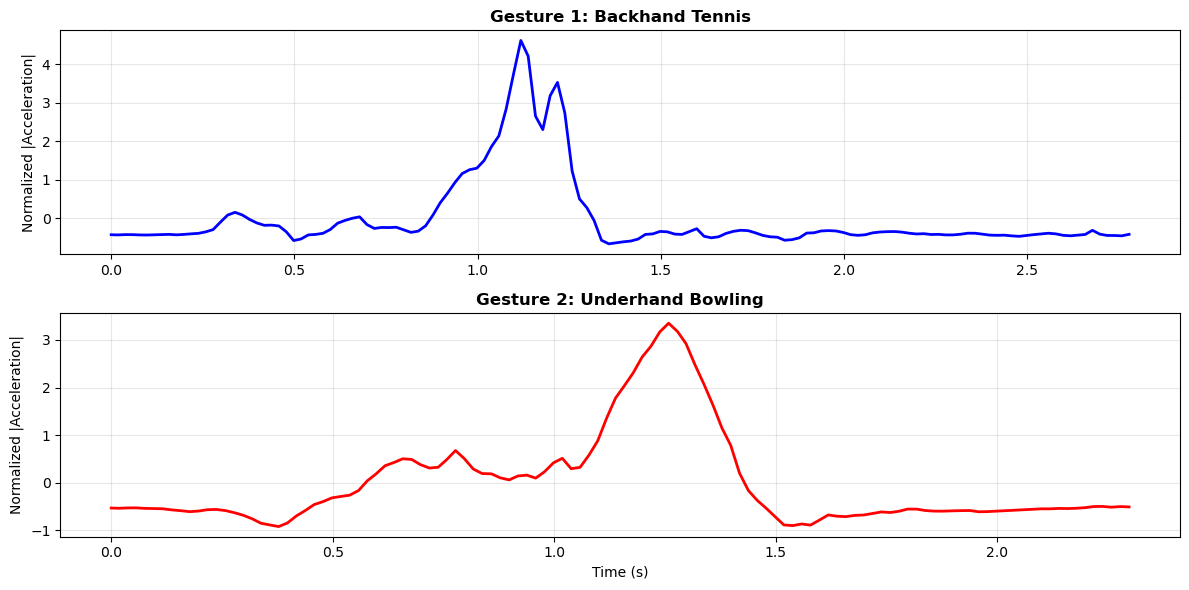

In [ ]:
def load_gesture(filepath):
    """Load and parse gesture data"""
    df = pd.read_csv(filepath)
    t_ms = df.iloc[:, 1].to_numpy()
    X = df.iloc[:, 3:6].to_numpy()
    t = (t_ms - t_ms[0]) / 1000.0
    return t, X


# Load two different gestures from the folder
gesture1_file = Path("./gestureLogs/....")
gesture2_file = Path("./gestureLogs/...")

gesture1_type = #fill in e.g., tennis, bowling, etc.
gesture2_type = #fill in e.g., tennis, bowling, etc.

t1, X1 = load_gesture(gesture1_file)
t2, X2 = load_gesture(gesture2_file)

# Compute magnitude
mag1 = np.linalg.norm(X1, axis=1)
mag2 = np.linalg.norm(X2, axis=1)

# Normalize
mag1_norm = (mag1 - np.mean(mag1)) / (np.std(mag1) + 1e-9)
mag2_norm = (mag2 - np.mean(mag2)) / (np.std(mag2) + 1e-9)

print(f"Gesture 1 ({gesture1_type}):  {len(mag1)} samples")
print(f"Gesture 2 ({gesture2_type}): {len(mag2)} samples")
print(f"Different lengths: {len(mag1) != len(mag2)}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(t1, mag1_norm, 'b-', linewidth=2)
axes[0].set_title(f'Gesture 1: {gesture1_type}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Normalized |Acceleration|')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t2, mag2_norm, 'r-', linewidth=2)
axes[1].set_title(f'Gesture 2: {gesture2_type}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Normalized |Acceleration|')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Part 2: Implement DTW

**Dynamic Time Warping** finds the optimal alignment between two time series — even when they have different lengths or timing.

**Algorithm (dynamic programming):**
1. Create cost matrix `D` of size `(n+1) × (m+1)`, initialized to `∞`
2. Set `D[0, 0] = 0`
3. For each cell `(i, j)`:
   ```
   D[i, j] = |a[i-1] - b[j-1]| + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
   ```
4. Return `D[n, m]`

In [4]:
def dtw_distance(a, b):
    """
    Compute DTW distance between two 1D signals.

    Args:
        a, b: 1D numpy arrays (can be different lengths)

    Returns:
        DTW distance (float)
    """
   

# --- Test your implementation ---
dtw_same = dtw_distance(mag1_norm[:50], mag1_norm[:50])
dtw_diff = dtw_distance(mag1_norm[:50], mag2_norm[:50])

print(f"DTW (same gesture): {dtw_same:.2f} (expected: ~0)")
print(f"DTW (different gestures): {dtw_diff:.2f} (expected: > 0)")

if dtw_same < dtw_diff:
    print("\n DTW working correctly!")
else:
    print("\n Check your implementation")

TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
# Compare DTW vs Euclidean on the full signals
L = min(len(mag1_norm), len(mag2_norm))
eucl_dist = np.linalg.norm(mag1_norm[:L] - mag2_norm[:L])

print(f"Euclidean distance: {eucl_dist:.2f}  (requires truncation to same length)")
print(f"DTW distance:       {dtw_distance(mag1_norm, mag2_norm):.2f}  (handles different lengths natively)")

---

## Part 3: k-NN Classifier Using DTW

- Store all training signals with their labels
- For a new signal, compute DTW distance to *every* training sample
- Predict the label by **majority vote** among the k nearest neighbors

In [ ]:
class KNN_DTW:
    """k-Nearest Neighbors classifier using DTW as the distance metric."""

    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """Store training data."""
        self.X_train = X_train
        self.y_train = y_train
        print(f"Stored {len(X_train)} training samples")

    def predict(self, test_signal):
        """
        Predict the label for a test signal.

        Steps:
        1. Compute DTW distance from test_signal to every training sample
        2. Find the k nearest neighbors (smallest distances)
        3. Return the majority vote label
        """
        # TODO: compute DTW distance to all training samples
        distances = # YOUR CODE HERE

        # TODO: find indices of k nearest neighbors
        k_nearest_indices = # YOUR CODE HERE
        k_nearest_labels  = # YOUR CODE HERE

        # TODO: return majority vote
        label_counts = #YOUR CODE HERE
        predicted_label =  #YOUR CODE HERE
        return predicted_label
    
    
    def score(self, X_test, y_test):
        """Compute accuracy on a test set."""
        predictions = [self.predict(x) for x in X_test]
        correct = sum(p == t for p, t in zip(predictions, y_test))
        return correct / len(y_test)


SyntaxError: invalid syntax (2279869772.py, line 25)

In [ ]:
# Load the full gesture dataset
def load_gestures(data_dir, gesture_types):
    """Load normalized magnitude signals for the given gesture types."""
    data_dir = Path(data_dir)
    X, y = [], []
    for gesture_name in gesture_types:
        files = sorted(data_dir.glob(f"{gesture_name}_Accelerometer_*.csv"))
        for filepath in files:
            df = pd.read_csv(filepath)
            acc = df.iloc[:, 3:6].to_numpy()
            mag = np.linalg.norm(acc, axis=1)
            mag_norm = (mag - np.mean(mag)) / (np.std(mag) + 1e-9)
            X.append(mag_norm)
            y.append(gesture_name)
    return X, y


gesture_types = ["Backhand Tennis", "Baseball Throw", "Shake"]
X_all, y_all = load_gestures("./gestureLogs", gesture_types)

# Stratified train/test split (70/30 per class)
from collections import defaultdict
class_indices = defaultdict(list)
for idx, label in enumerate(y_all):
    class_indices[label].append(idx)

train_idx, test_idx = [], []
for label, indices in class_indices.items():
    indices = np.array(indices)
    np.random.shuffle(indices)
    n_test = max(1, int(len(indices) * 0.3))
    test_idx.extend(indices[:n_test])
    train_idx.extend(indices[n_test:])

X_train = [X_all[i] for i in train_idx]
X_test  = [X_all[i] for i in test_idx]
y_train = [y_all[i] for i in train_idx]
y_test  = [y_all[i] for i in test_idx]

lengths = [len(s) for s in X_all]
print(f"Loaded {len(X_all)} samples across {len(gesture_types)} classes")
print(f"Signal lengths: {min(lengths)}–{max(lengths)} samples (different lengths!)")
print(f"Train: {len(X_train)}  |  Test: {len(X_test)}")

In [ ]:
# Visualize one example per gesture class
fig, axes = plt.subplots(1, len(gesture_types), figsize=(15, 4))
colors = ['b', 'g', 'r']

for ax, cls, color in zip(axes, gesture_types, colors):
    sample = X_train[y_train.index(cls)]
    ax.plot(sample, f'{color}-', linewidth=2)
    ax.set_title(cls, fontsize=11, fontweight='bold')
    ax.set_xlabel('Sample')
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Normalized Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
# Train and evaluate your k-NN classifier
knn = KNN_DTW(k=3)
knn.fit(X_train, y_train)

accuracy = knn.score(X_test, y_test)
print(f"\nAccuracy: {accuracy * 100:.1f}%")

print("\nIndividual predictions:")
for i, (sig, true_label) in enumerate(zip(X_test, y_test)):
    pred = knn.predict(sig)
    status = "" if pred == true_label else "x"
    print(f"Test {i+1}: true={true_label:20s} predicted={pred:20s} {status}")

---

## Step 4: k-NN with Euclidean Distance

Re-implement k-NN using **Euclidean distance** instead of DTW.  
Since Euclidean requires equal-length signals, truncate both to the shorter length before comparing.

How does accuracy compare?

In [ ]:
class KNN_Euclidean:
    """k-NN using Euclidean distance (for comparison with DTW)."""

    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, test_signal):
        # TODO: compute Euclidean distance to all training samples
        #       truncate both signals to the shorter length before comparing
        distances = # YOUR CODE HERE

        k_nearest_indices = # YOUR CODE HERE
        k_nearest_labels  = # YOUR CODE HERE
        label_counts = Counter(k_nearest_labels)
        return label_counts.most_common(1)[0][0]

    def score(self, X_test, y_test):
        predictions = [self.predict(x) for x in X_test]
        correct = sum(p == t for p, t in zip(predictions, y_test))
        return correct / len(y_test)


# --- Compare both classifiers ---
knn_euc = KNN_Euclidean(k=3)
knn_euc.fit(X_train, y_train)

acc_dtw = knn.score(X_test, y_test)
acc_euc = knn_euc.score(X_test, y_test)

print(f"DTW accuracy:       {acc_dtw * 100:.1f}%")
print(f"Euclidean accuracy: {acc_euc * 100:.1f}%")